In [60]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

import fastf1
import fastf1.plotting

from matplotlib.ticker import FuncFormatter

import os
import time

cache_folder = 'cache_folder'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)
fastf1.Cache.enable_cache(cache_folder)

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

year = int(input('Year ? '))
race_number = int(input('Race Number ? (1-24) '))
race_session = input('Session ? (R, S)')

session = fastf1.get_session(year, race_number, race_session)
session.load()

filename = f'/home/kurios/Documents/f1_analysis/reports/figures/{race_number}_{session.event["EventName"]}_{session.event.year}_Race/'
os.makedirs(os.path.dirname(filename), exist_ok=True)
os.chdir(filename)

event_name = session.event.EventName
circuit_info = session.get_circuit_info()
teams = fastf1.plotting.list_team_names(session)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	Using cached data for driver_info
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api    

In [61]:
def seconds_to_mmss(x, pos):
    minutes = int(x // 60)
    seconds = x % 60
    return f"{minutes}:{seconds:05.2f}"

def show_laptime_comp(team_drivers, session):
    driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+1))).reset_index()
    driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+1))).reset_index()
    if len(driver_1_laps) > 1 :
        driver_1_laps.loc[0, 'LapTime'] = driver_1_laps.loc[1, 'LapStartTime'] - driver_1_laps.loc[0, 'LapStartTime']
    if len(driver_2_laps)>1:
        driver_2_laps.loc[0, 'LapTime'] = driver_2_laps.loc[1, 'LapStartTime'] - driver_2_laps.loc[0, 'LapStartTime']

    last_lap = int(max(session.laps['LapNumber']))

    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(driver_1_laps['LapNumber'], driver_1_laps['LapTime'], color=team_color)
    ax.plot(driver_2_laps['LapNumber'], driver_2_laps['LapTime'], color=team_color_2)
    ax.tick_params(labelright=True)
    ax.set_xlim([0, last_lap])
    
    plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
    
    plt.grid(color='w', which='major', axis='both', linestyle='dotted')
    os.chdir(filename)
    plt.savefig(fname=f'{session.name}_{team}_laptime_comp', transparent=True)
    
def show_laptime_scatterplot(team_drivers, session):
    driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+1))).reset_index()
    driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+1))).reset_index()

    if len(driver_1_laps) > 1:
        driver_1_laps.loc[0, 'LapTime'] = driver_1_laps.loc[1, 'LapStartTime'] - driver_1_laps.loc[0, 'LapStartTime']
    if len(driver_2_laps) > 1:
        driver_2_laps.loc[0, 'LapTime'] = driver_2_laps.loc[1, 'LapStartTime'] - driver_2_laps.loc[0, 'LapStartTime']
    driver_1_valid = driver_1_laps['LapTime'].dropna()
    driver_2_valid = driver_2_laps['LapTime'].dropna()

    if driver_1_valid.empty and driver_2_valid.empty:
        print("No valid lap times to display.")
        return
    elif driver_1_valid.empty:
        min_laptime = min(driver_2_valid)
        max_laptime = max(driver_2_valid)
    elif driver_2_valid.empty:
        min_laptime = min(driver_1_valid)
        max_laptime = max(driver_1_valid)
    else:
        min_laptime = min(min(driver_1_valid), min(driver_2_valid))
        max_laptime = max(max(driver_1_valid), max(driver_2_valid))

    
    min_laptime = min_laptime - \
                        timedelta(seconds= 1)
    max_laptime = max_laptime + \
                        timedelta(seconds= 1)
    print(min_laptime, max_laptime)
    last_lap = int(max(session.laps['LapNumber'])) + 1
    
    fig, ax = plt.subplots(figsize=(5.75, 4.2))
    
    sns.scatterplot(data=driver_1_laps,
                    x="LapNumber",
                    y="LapTime",
                    hue = 'Compound',
                    palette=fastf1.plotting.get_compound_mapping(session=session),
                    edgecolor = team_color,
                    style="Compound",
                    s=50,
                    linewidth=0.5)
    
    sns.scatterplot(data=driver_2_laps,
                    x="LapNumber",
                    y="LapTime",
                    hue = 'Compound',
                    palette=fastf1.plotting.get_compound_mapping(session=session),
                    edgecolor = team_color_2,
                    style="Compound",
                    s=50,
                    linewidth=0.5)
    
    ax.invert_yaxis()
    ax.tick_params(labelleft=False)
    ax.set_xlim([0, last_lap])
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.set_ylim([min_laptime, max_laptime])
    plt.tick_params(left = False)
    plt.tick_params(bottom = False)
    plt.legend(frameon=False)
    plt.grid(color='w', which='major', axis='both', linestyle='dotted')

    plt.tight_layout()
    os.chdir(filename)
    plt.savefig(fname=f'{session.name}_{team}_laptime_scatterplot', transparent=True)

def show_pace_comp(team_drivers, session):
    driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_laps(range(0, (int(max(session.laps['LapNumber'])) + 1))).reset_index()
    driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_laps(range(0, (int(max(session.laps['LapNumber'])) + 1))).reset_index()

    if len(driver_1_laps) > 1:
        driver_1_laps.loc[0, 'LapTime'] = driver_1_laps.loc[1, 'LapStartTime'] - driver_1_laps.loc[0, 'LapStartTime']
    if len(driver_2_laps) > 1:
        driver_2_laps.loc[0, 'LapTime'] = driver_2_laps.loc[1, 'LapStartTime'] - driver_2_laps.loc[0, 'LapStartTime']

    transformed_driver_1_laps = driver_1_laps.copy()
    transformed_driver_2_laps = driver_2_laps.copy()
    transformed_driver_1_laps["LapTime"] = transformed_driver_1_laps["LapTime"].dt.total_seconds()
    transformed_driver_2_laps["LapTime"] = transformed_driver_2_laps["LapTime"].dt.total_seconds()

    all_laptimes = []
    if not transformed_driver_1_laps.empty:
        all_laptimes.extend(transformed_driver_1_laps["LapTime"].dropna())
    if not transformed_driver_2_laps.empty:
        all_laptimes.extend(transformed_driver_2_laps["LapTime"].dropna())

    if not all_laptimes:
        print("No valid lap times to display.")
        return

    min_laptime = min(all_laptimes) - 1
    max_laptime = max(all_laptimes) + 1

    plt.rcParams.update({
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False,
        'font.size': 12
    })

    fig, ax = plt.subplots(figsize=(2.5, 4.2))
    if "LapTime" in transformed_driver_1_laps.columns and transformed_driver_1_laps["LapTime"].dropna().size > 0:
        sns.boxplot(
            data=transformed_driver_1_laps,
            y="LapTime",
            color=team_color,
            linecolor='white',
            whiskerprops=dict(color="white"),
            boxprops=dict(edgecolor="white"),
            medianprops=dict(color="grey"),
            capprops=dict(color="white"),
        )

    ax.set_ylim([max_laptime, min_laptime])
    ax.invert_yaxis()
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(bottom=False)
    ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_mmss))

    plt.xticks(visible=False)
    plt.grid(color='w', which='major', axis='y', linestyle='dotted')
    plt.tight_layout()
    os.chdir(filename)
    plt.savefig(fname=f'{session.name}_{team}_driver_1_pace', transparent=True)

    fig, ax = plt.subplots(figsize=(2.5, 4.2))
    if "LapTime" in transformed_driver_2_laps.columns and transformed_driver_2_laps["LapTime"].dropna().size > 0:
        sns.boxplot(
            data=transformed_driver_2_laps,
            y="LapTime",
            color=team_color_2,
            linecolor='white',
            whiskerprops=dict(color="white"),
            boxprops=dict(edgecolor="white"),
            medianprops=dict(color="grey"),
            capprops=dict(color="white"),
        )

    ax.set_ylim([max_laptime, min_laptime])
    ax.invert_yaxis()
    ax.set(xlabel=None, ylabel=None)
    ax.yaxis.tick_right()
    ax.tick_params(bottom=False)
    ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_mmss))

    plt.xticks(visible=False)
    plt.grid(color='w', which='major', axis='y', linestyle='dotted')
    plt.tight_layout()
    os.chdir(filename)
    plt.savefig(fname=f'{session.name}_{team}_driver_2_pace', transparent=True)

    
def show_tyre_strategy(team_drivers, session):
    fig, ax = plt.subplots(figsize=(9.2, 1.2))
    
    driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+2))).reset_index()
    driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_laps(range(0, (int(max(session.laps['LapNumber']))+2))).reset_index()
    if len(driver_1_laps) > 1 :
        driver_1_laps.loc[0, 'LapTime'] = driver_1_laps.loc[1, 'LapStartTime'] - driver_1_laps.loc[0, 'LapStartTime']
    if len(driver_2_laps)>1:
        driver_2_laps.loc[0, 'LapTime'] = driver_2_laps.loc[1, 'LapStartTime'] - driver_2_laps.loc[0, 'LapStartTime']
    last_lap = int(max(session.laps['LapNumber']))
    
    for driver in team_drivers:
        laps = session.laps.pick_drivers(driver)
        stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
        stints = stints.groupby(["Driver", "Stint", "Compound"])
        stints = stints.count().reset_index()
        stints = stints.rename(columns={"LapNumber": "StintLength"})
        
        driver_stints = stints.loc[stints["Driver"] == driver]

        previous_stint_end = 0
        for idx, row in driver_stints.iterrows():
            compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                                session=session)
            plt.barh(
                y=driver,
                width=row["StintLength"],
                height = 0.4,
                align='center',
                left=previous_stint_end,
                color=compound_color,
                edgecolor="black",
                fill=True
            )

            previous_stint_end += row["StintLength"]

    plt.grid(False)
    plt.grid(color='w', which='major', axis='x', linestyle='dotted')

    ax.xaxis.tick_top()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([0, last_lap])

    plt.tight_layout()
    os.chdir(filename)
    plt.savefig(fname=f'{session.name}_{team}_tyre_strategy', transparent=True)


0 days 00:01:31.280000 0 days 00:02:46.662000
0 days 00:01:32.150000 0 days 00:02:29.529000
0 days 00:01:31.396000 0 days 00:02:10.532000
0 days 00:01:31.745000 0 days 00:02:27.202000


/tmp/ipykernel_943/3987749058.py:138: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(2.5, 4.2))


0 days 00:01:31.192000 0 days 00:02:13.726000
0 days 00:01:31.466000 0 days 00:02:18.716000
0 days 00:01:32.446000 0 days 00:02:31.123000
0 days 00:01:31.998000 0 days 00:02:24.233000
0 days 00:01:32.238000 0 days 00:02:30.717000
0 days 00:01:30.778000 0 days 00:02:17.374000


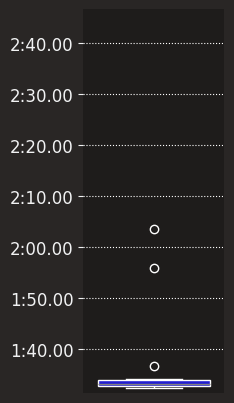

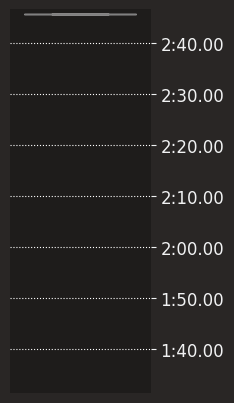

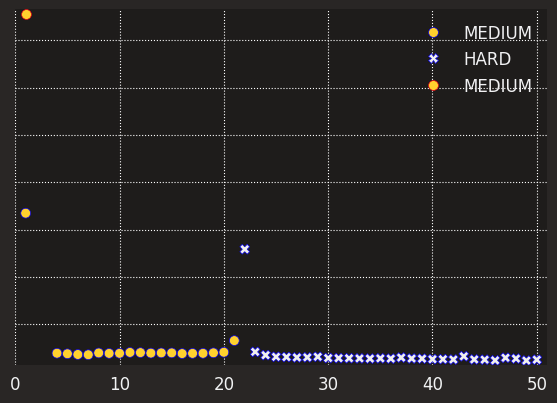

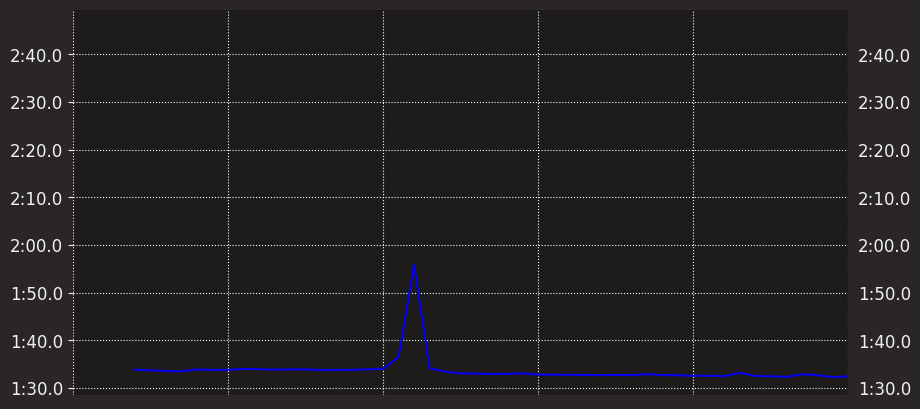

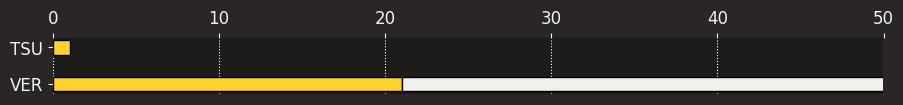

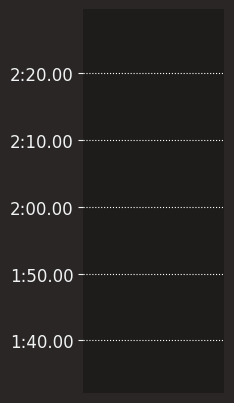

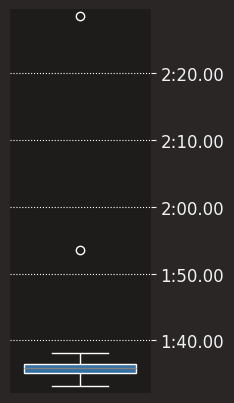

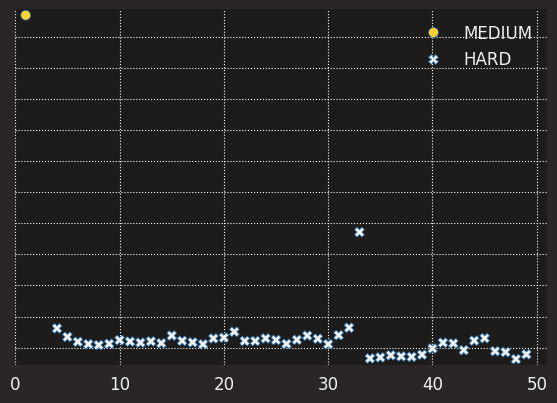

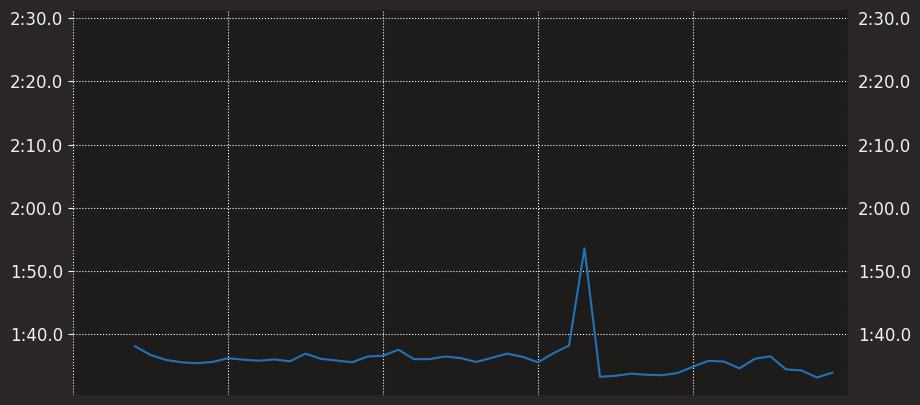

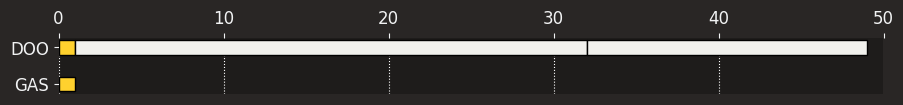

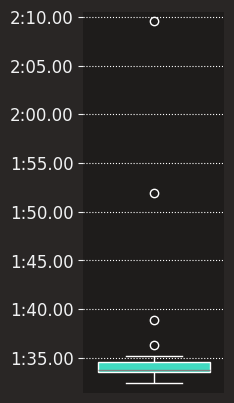

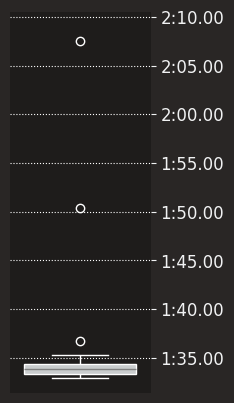

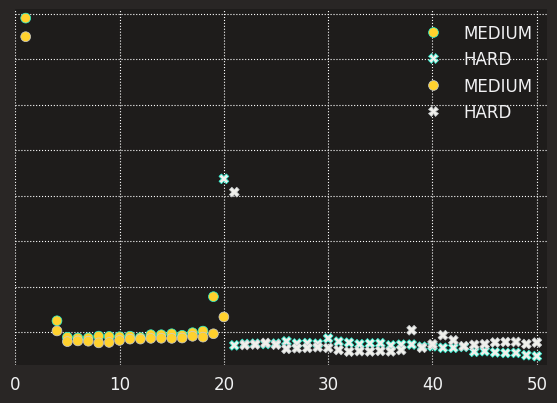

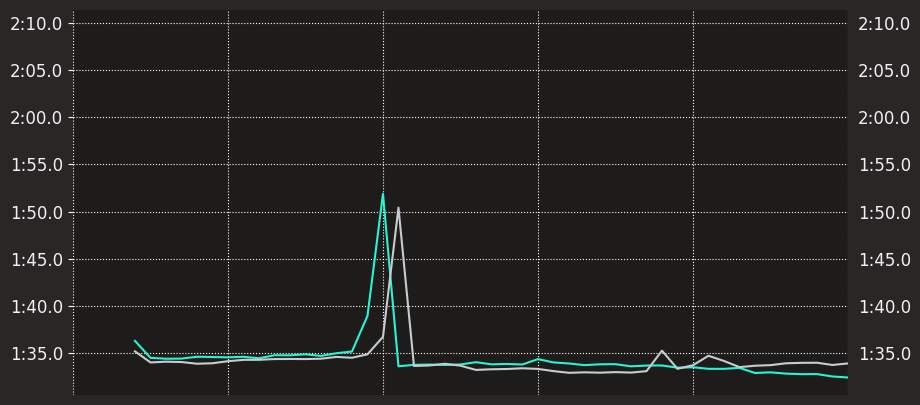

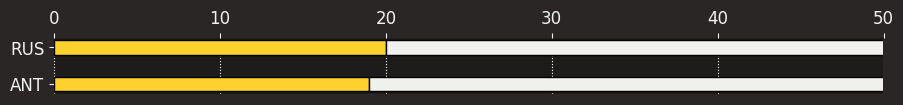

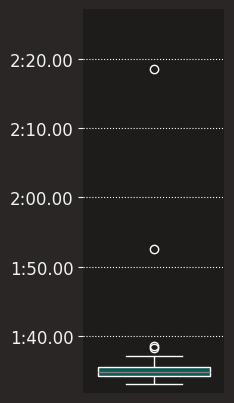

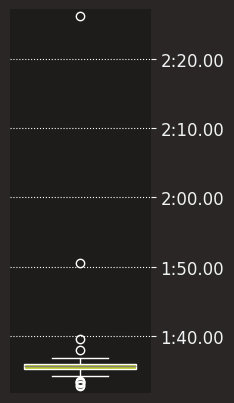

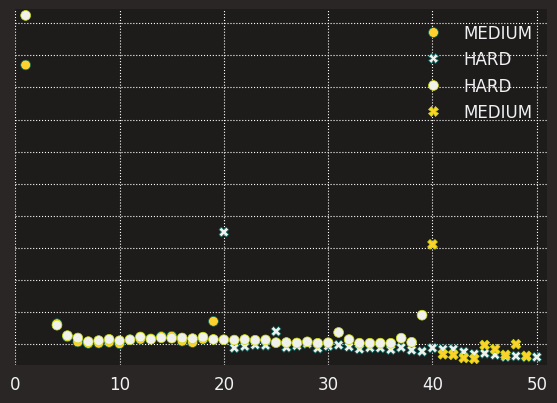

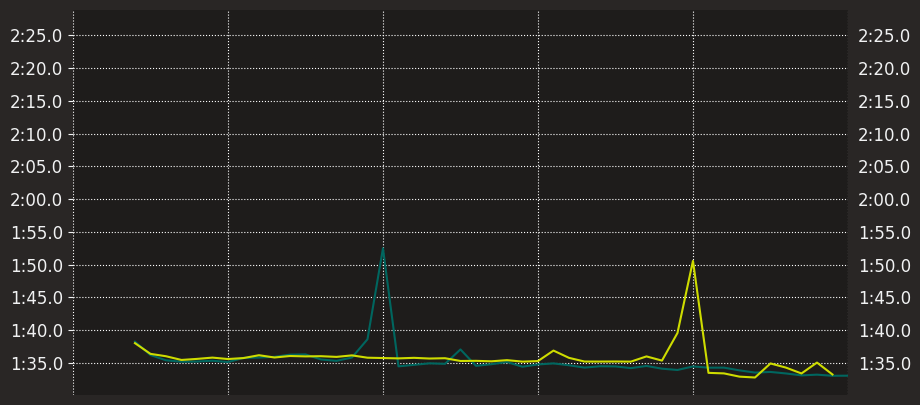

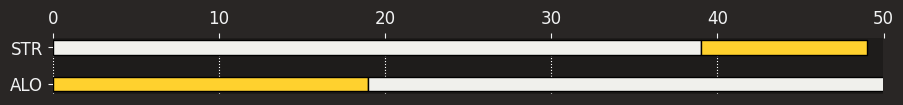

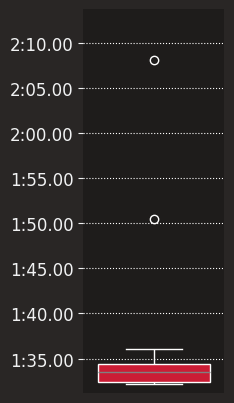

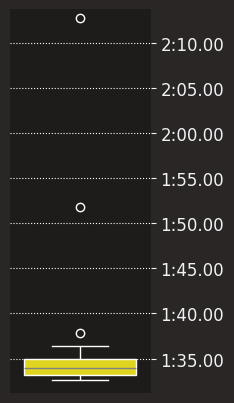

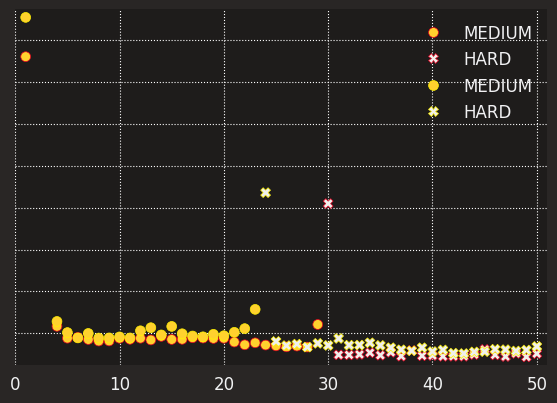

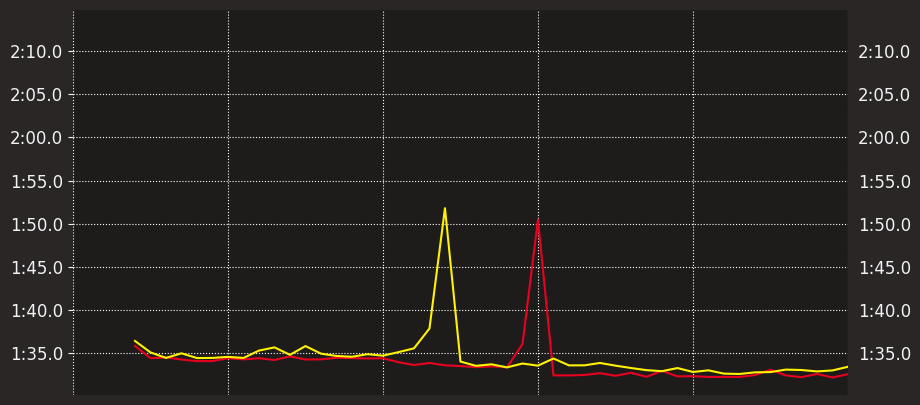

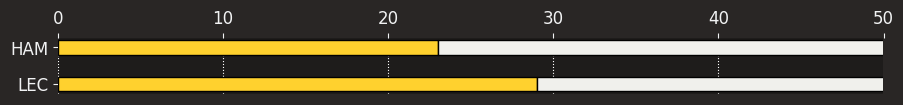

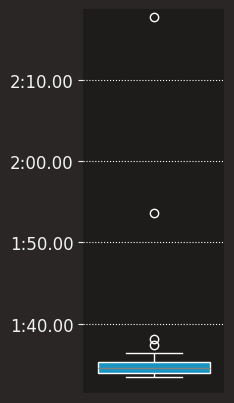

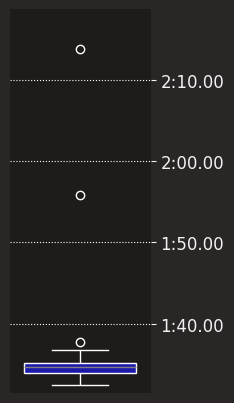

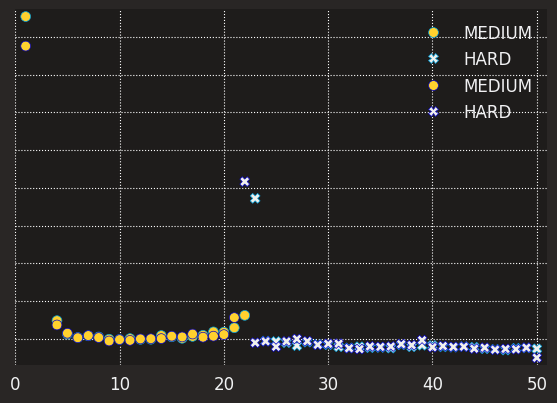

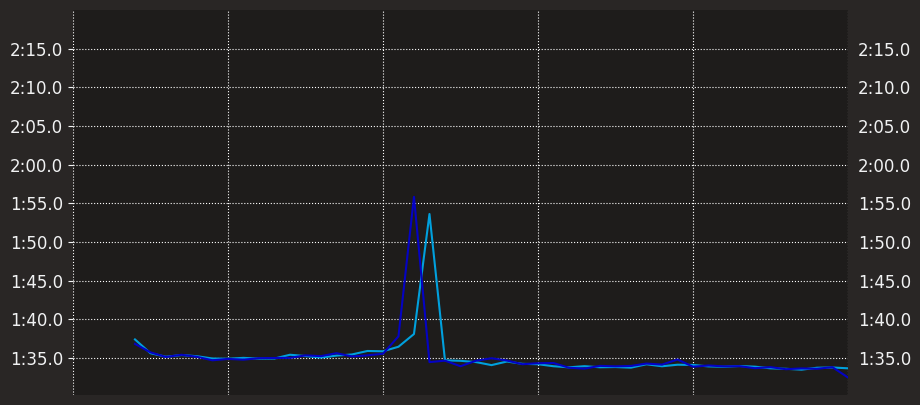

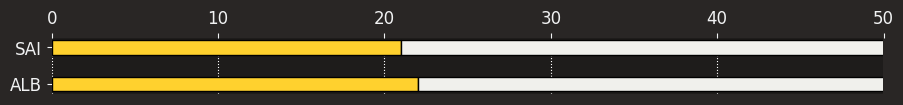

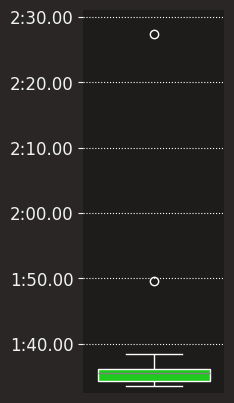

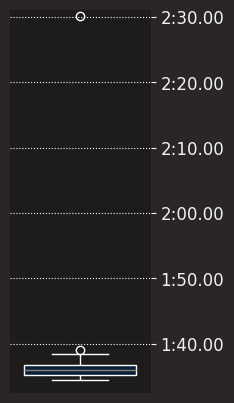

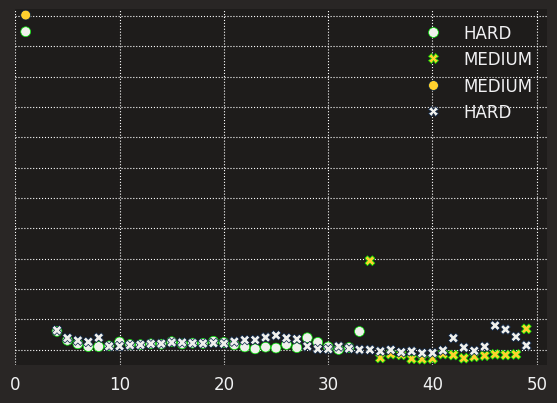

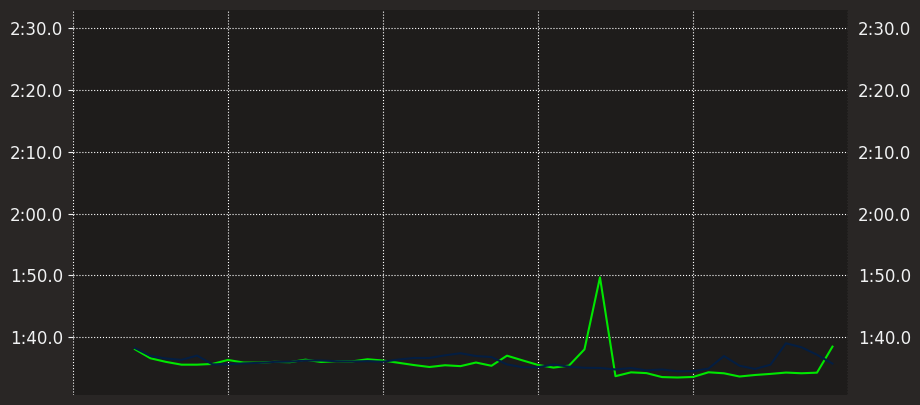

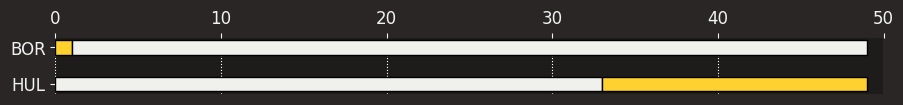

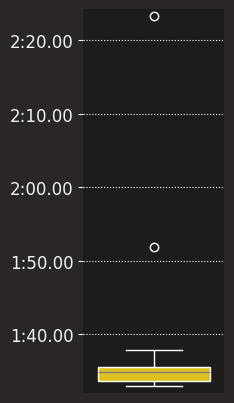

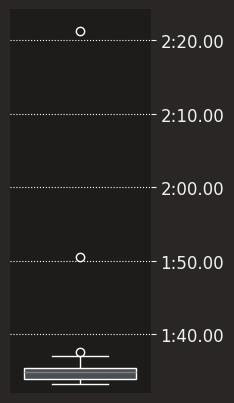

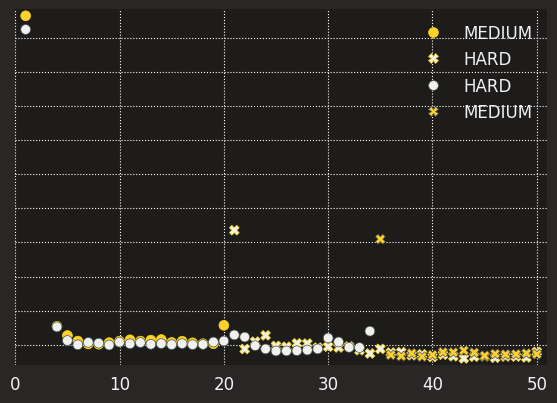

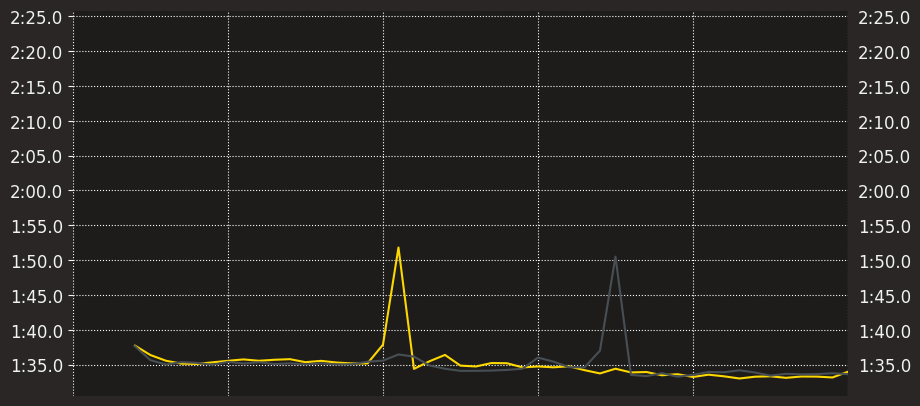

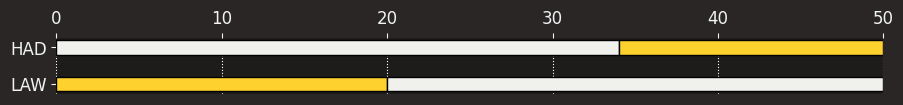

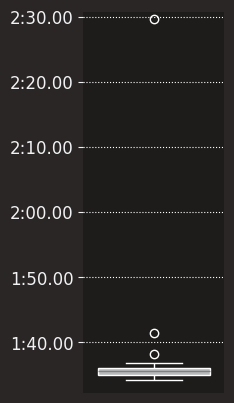

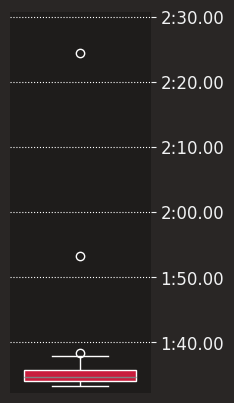

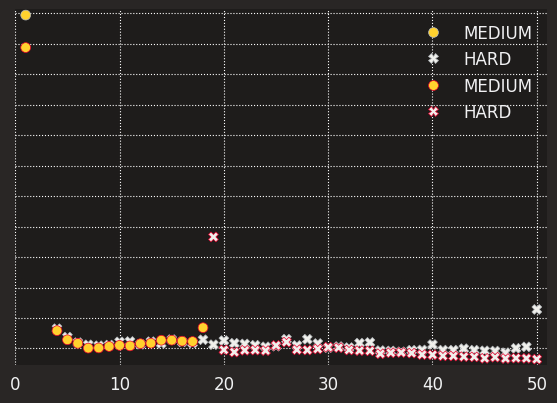

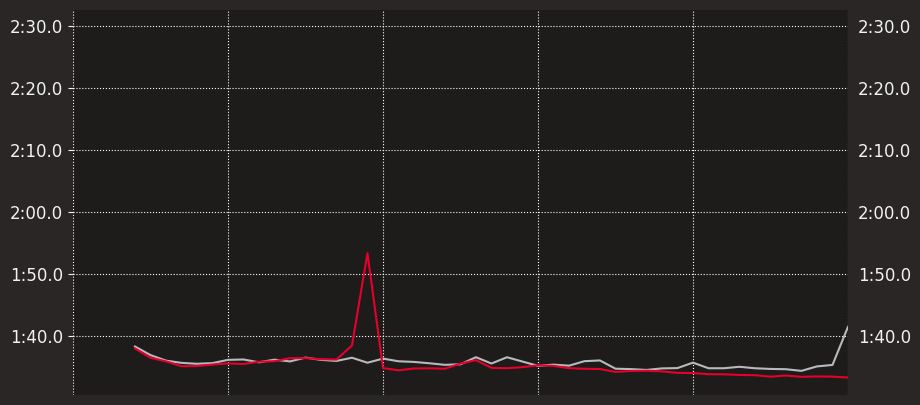

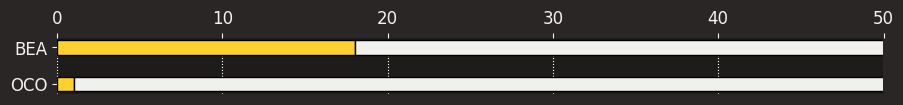

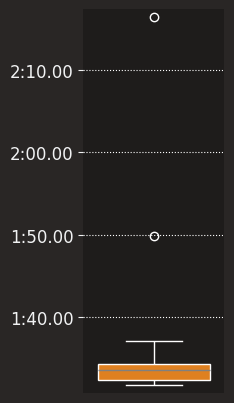

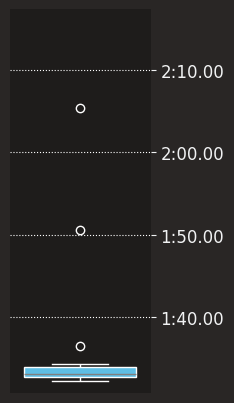

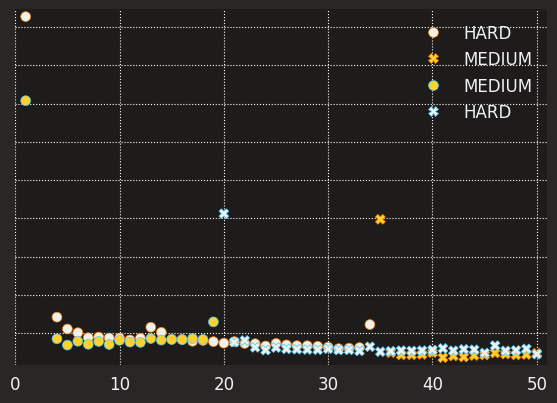

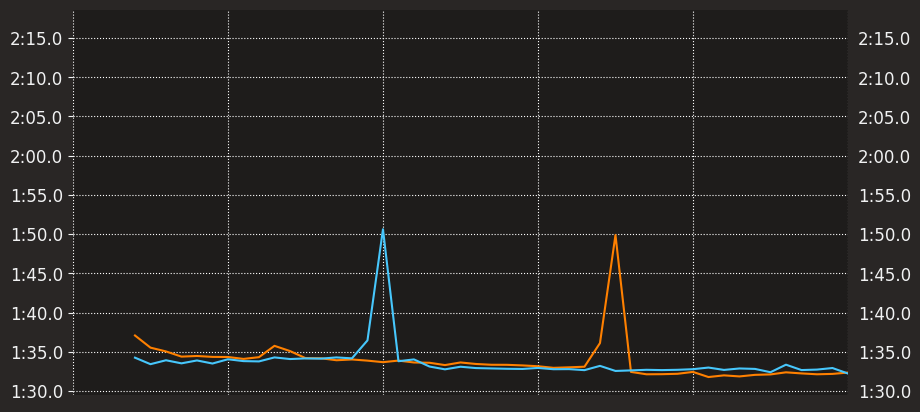

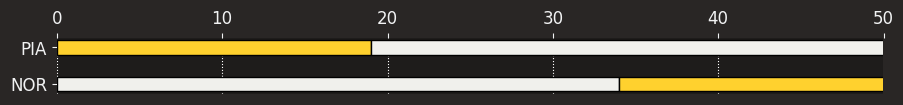

In [59]:
for idx,team in enumerate(teams):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    team_color = fastf1.plotting.get_team_color(team, session=session)
    df_color=pd.read_csv("/home/kurios/Documents/f1_analysis/data/raw/second_color.csv", index_col='team')
    team_color_2 = df_color.iat[idx,0]
    #try:
    show_pace_comp(team_drivers, session)
    show_laptime_scatterplot(team_drivers, session)
    show_laptime_comp(team_drivers, session)
    show_tyre_strategy(team_drivers, session)
    #except:
        #print(f'No data for {team}')